In [65]:
%matplotlib inline
import pandas as pd

def date_parser(string_list):
    return [time.ctime(float(x)) for x in string_list]

posts_index = pd.read_csv("../data/posts-index.csv", delimiter="|", error_bad_lines=False)
posts_data =pd.read_csv("../data/posts-data.csv", delimiter="|", error_bad_lines=False)

posts_index = posts_index.assign(date=pd.to_datetime(posts_index['created_at'], unit='s').values).set_index("post_id")

def to_minute_of_day(timestamp):
    minute = (timestamp.hour * 60) + timestamp.minute
    return round(minute / 30) * 30

posts_index = posts_index.assign(minute_of_day=posts_index['date'].map(to_minute_of_day))

scores = posts_data.groupby("post_id")["ups"].max() - posts_data.groupby("post_id")["downs"].max()
posts = posts_index.assign(score=scores).dropna(subset=['score'])

subreddit_names = {
    "t5_2qh55": "food",
    "t5_2roy3": "dessert",
    "t5_2qjlb": "foodie",
    "t5_2s2i4": "FoodNews",
    "t5_2rd9v": "foodporn",
    "t5_2rcvg": "grilling",
    "t5_2rhbm": "healthyfood",
    "t5_2qh56": "recipes",
    "t5_2skqy": "pressurecooking",
    "t5_2s64w": "slowcooking",
    "t5_2rzyz": "sousvide",
    "t5_2qkku": "smoking",
    "t5_2qxea": "tonightsdinner",
    "t5_30sp1": "seriouseats",
    "t5_2qxww": "BBQ",
    "t5_2qh7f": "Cooking"
}

subreddits = posts['subreddit_id'].map(lambda x: subreddit_names[x])
posts = posts.assign(subreddit=subreddits)

b'Skipping line 819: expected 6 fields, saw 11\nSkipping line 13428: expected 6 fields, saw 7\nSkipping line 21985: expected 6 fields, saw 98\n'


In [68]:
popular_subs = ['food', 'foodporn', 'recipes', 'sousvide', 'slowcooking', 'healthygood', 'grilling']

In [69]:
minute_of_day_result = {}
resampled_result = {}

for sub in popular_subs:
    sub_posts = posts[posts['subreddit'] == sub]
    minute_of_day_result[sub] = sub_posts['minute_of_day']
    resampled_result[sub] = sub_posts.resample('D', on='date')['score'].quantile(0.25)

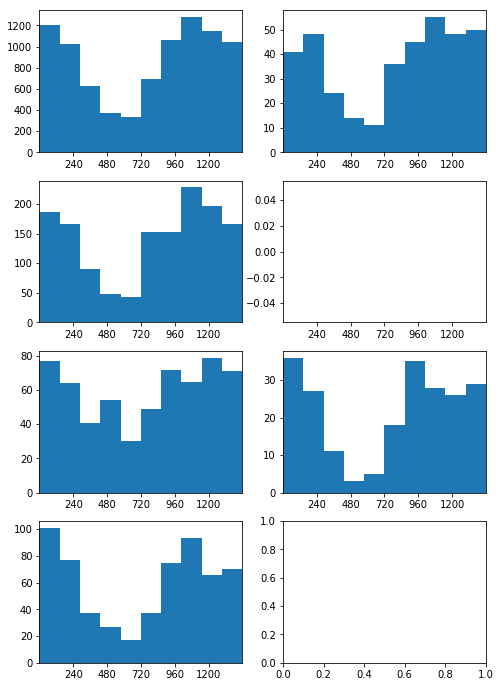

In [71]:
import matplotlib.pyplot as plt

total_plots = 7
num_rows = 4
num_cols = 2


fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols)
fig.set_size_inches(8,12)
for row_n in range(num_rows):
    for col_n in range(num_cols):
        i = (col_n * num_rows) + row_n
        if i >= total_plots:
            continue
        
        sub = popular_subs[i]
        ax = axs[row_n][col_n]
        ax.hist(minute_of_day_result[sub])
#         result[sub_id].hist(bins=48, ax=ax)
        ax.set_xlim(0, 1440)
        ax.set_xticks([240, 480, 720, 960, 1200])


Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


IndexError: list index out of range

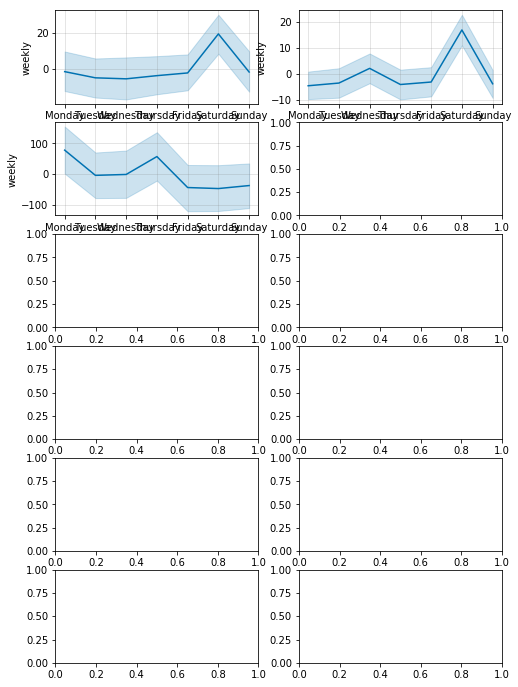

In [73]:
import matplotlib.pyplot as plt
from fbprophet import Prophet

resampled_result_list = [v for _, v in resampled_result.items()]

def to_prophet_df(index):
    series = resampled_result_list[index]
    return pd.DataFrame({"ds": series.index, "y": series.values})

total_plots = 11
num_rows = 6
num_cols = 2


fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols)
fig.set_size_inches(8,12)
for row_n in range(num_rows):
    for col_n in range(num_cols):
        i = (col_n * num_rows) + row_n
        if i >= total_plots:
            continue
        
        sub = popular_subs[i]
        
        m = Prophet(mcmc_samples=500)
        m.fit(to_prophet_df(i));

        ax = axs[row_n][col_n]
        m.plot_weekly(ax=ax,uncertainty=True, weekly_start=1)
